# 1 Setting Up Environment

In [583]:
# 1 Setting Up Environment
import isort
script_path = 'imports.py'
# Sorting the imports in the script
isort.file(script_path)
from imports import *
# For displaying plots inline
%matplotlib inline

# 2. Loading & Preparing Data For Model

## 2.1 Train/Test Split

In [584]:
def data_split(df, date_col, split_date):
    """
    Splits the given DataFrame into training and testing sets based on a split date.

    Args:
        df (pd.DataFrame): The input DataFrame with a 'DATE' column for time-based splitting.
        date_col (str): The name of the column containing the date values.
        split_date (str): The date in 'YYYY-MM' format to split the data.
                         All rows before this date will be in the training set, and 
                         rows from this date onward will be in the test set.

    Returns:
        tuple: A tuple containing:
            - train_df (pd.DataFrame): DataFrame with rows before the split date.
            - test_df (pd.DataFrame): DataFrame with rows from the split date onward.
    """
    # Set the DataFrame index to the date_col column for time-based slicing
    df.index = df[date_col]
    
    # Dropping the original 'DATE' column as it's now redundant
    df.drop(columns=[date_col], inplace=True)
    
    # Splitting the DataFrame into training and testing sets
    train_df = df[df.index < split_date]
    test_df = df[df.index >= split_date]

    # Selecting features representing diverse aspects of the data (e.g., liquidity, reserves, loans)
    # These features have been selected after thorough analysis and research has been performed, making sure to apply domain knowledge as well. 
    selected_features = [
                         'GR_MAGNITUDE_NET_INTEREST_INCOME',
                         'GR_MAGNITUDE_EQUITY_TO_LOAN_RATIO', 
                         'GR_MAGNITUDE_RESERVE_SENSITIVITY', 
                         'GR_MAGNITUDE_LDR', 
                         'GR_MAGNITUDE_REAL_ESTATE_LOAN_RATIO', 
                         'GR_MAGNITUDE_RESERVE_TO_DEPOSIT_RATIO', 
                         'GR_MAGNITUDE_INTEREST_RATE', 
                         'GR_MAGNITUDE_DELINQUENCY_RATES_LOANS', 
                         'GR_MAGNITUDE_LOAN_CHARGE_OFF'
                         ] + ['STRESS_FLAG']
    train_df = train_df[selected_features]
    test_df = test_df[selected_features]
    return train_df, test_df

# Loading the data
df = pd.read_csv('data_ready_for_model.csv')
df.loc[(df['STRESS_FLAG'] == 2), 'STRESS_FLAG'] = 1
# This date was selected as TimeSeriesSplit will be performed later on the train set. 
# This split ensures that there is at least one recession period that is followed by systemic stress events.
# By doing this split we maintain the appropriate split ratio around 15% test and 85% train.
# The TimeSeriesSplit (n=3) was selected to make sure that the model is tested on various periods were in each one systemic events and recession periods occur.
train_df, test_df = data_split(df, 'DATE', '2019-01')

# 3. Fit Model

## 3.1 BayesianSearchCV w/ TimeSeriesSplit

In [585]:
def bayesian_search_cv_binary(train_df, 
                              target_column, 
                              n_estimators_range, 
                              max_depth_range, 
                              learning_rate_range, 
                              scale_pos_weight_range, 
                              weight_positive_range,
                              weight_negative_range,
                              n_splits, 
                              scoring_type,
                              alpha,
                              lambda_,
                              gamma):
    """
    Perform Bayesian Search CV with TimeSeriesSplit for a binary XGBoost model, including scale_pos_weight 
    and custom weights as hyperparameters.

    Parameters:
        train_df (pd.DataFrame): Training dataset.
        target_column (str): Name of the target column.
        n_estimators_range (tuple): Range of n_estimators (min, max).
        max_depth_range (tuple): Range of max_depth (min, max).
        learning_rate_range (tuple): Range of learning rate (min, max, 'log-uniform').
        scale_pos_weight_range (tuple): Range of scale_pos_weight (min, max).
        weight_positive_range (tuple): Range of weight_positive (min, max).
        weight_negative_range (tuple): Range of weight_negative (min, max).
        n_splits (int): Number of TimeSeriesSplit folds.
        scoring_type (str): Metric to optimize (e.g., 'roc_auc').
        alpha (tuple): Range of alpha (min, max, 'log-uniform').
        lambda_ (tuple): Range of lambda (min, max, 'log-uniform').
        gamma (tuple): Range of gamma (min, max, 'uniform').

    Returns:
        BayesSearchCV: Fitted Bayesian Search CV object.
    """

    # Defining features and target
    X = train_df.drop(columns=[target_column])
    y = train_df[target_column]

    # Defining hyperparameter space for Bayesian optimization
    param_space = {
        'n_estimators': n_estimators_range,             # Number of trees in the ensemble.
        'max_depth': max_depth_range,                   # Maximum depth of each tree to control overfitting.
        'learning_rate': learning_rate_range,           # Step size for weight updates to control convergence.
        'scale_pos_weight': scale_pos_weight_range,     # Balance positive and negative classes for imbalanced data.
        'weight_positive': weight_positive_range,       # Weight applied to false negatives to reduce their impact.
        'weight_negative': weight_negative_range,       # Weight applied to false positives to reduce their impact.
        'alpha': alpha,                                 # L1 regularization to prevent overfitting by feature selection.
        'lambda': lambda_,                              # L2 regularization to shrink coefficients and prevent overfitting.
        'gamma': gamma,                                 # Minimum loss reduction required to split a node.
    }

    # Initializing TimeSeriesSplit
    # Validation Set Size Formula: Total Observations / (n_splits + 1), Total Observations = 1990 to 2018 --> 348 months
    # In our case n = 3 --> 348 / (3 + 1) = 87 months, this is the smallest train set size hence to avoid curse of dimensionality, 8-9 features should be used as input features.
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Initializing Bayesian Search CV
    bayes_search = BayesSearchCV(
        estimator= customized_classifier.CustomXGBClassifier(weight_positive=weight_positive_range[0], weight_negative=weight_negative_range[0], random_state=42),  
        search_spaces=param_space,
        scoring=scoring_type,
        cv=tscv,
        n_iter=100,
        verbose=0,  
        random_state=42
    )

    # Fitting Bayesian Search CV
    bayes_search.fit(X, y)

    # Output the best hyperparameters and CV score
    print("Best Hyperparameters:", bayes_search.best_params_)
    print("Best CV Score:", bayes_search.best_score_)

    return bayes_search

n_estimators_range =  (50, 500)                    # Number of trees
max_depth_range = (3, 6)                           # Tree depth
learning_rate_range = (0.01, 0.2, 'log-uniform')   # Learning rate
scale_pos_weight_range = (1.0, 4.0)                # Class imbalance handling
weight_positive_range = (1.0, 10.0)                # False negatives weight
weight_negative_range = (0.5, 2.0)                 # False positives weight
n_splits = 3                                       # Number of TimeSeriesSplit folds
scoring_type = 'roc_auc'                           # Metric to optimize
alpha = (1e-4, 1.0, 'log-uniform')                 # L1 regularization
lambda_ = (1e-4, 1.0, 'log-uniform')               # L2 regularization
gamma =  (0.0, 5.0, 'uniform')                     # Minimum loss reduction


# Calling the function for binary classification
best_model = bayesian_search_cv_binary(
    train_df=train_df,
    target_column='STRESS_FLAG',
    n_estimators_range=n_estimators_range,
    max_depth_range=max_depth_range,
    learning_rate_range=learning_rate_range,
    scale_pos_weight_range=scale_pos_weight_range,
    weight_positive_range=weight_positive_range,
    weight_negative_range=weight_negative_range,
    n_splits=n_splits,
    scoring_type=scoring_type,
    alpha=alpha,
    lambda_=lambda_,
    gamma=gamma
)

'''
Best Hyperparameters: OrderedDict(
                                    [('alpha', 0.0001), 
                                    ('gamma', 0.0), 
                                    ('lambda', 0.013803874579275194), 
                                    ('learning_rate', 0.07336779658938043), 
                                    ('max_depth', 3), 
                                    ('n_estimators', 466), 
                                    ('scale_pos_weight', 1.3766880279484466), 
                                    ('weight_negative', 0.7609398888462372), 
                                    ('weight_positive', 10.0)]
                                )
Best CV Score: 0.8527383048602495
'''

Best Hyperparameters: OrderedDict([('alpha', 0.0001), ('gamma', 0.0), ('lambda', 0.013803874579275194), ('learning_rate', 0.07336779658938043), ('max_depth', 3), ('n_estimators', 466), ('scale_pos_weight', 1.3766880279484466), ('weight_negative', 0.7609398888462372), ('weight_positive', 10.0)])
Best CV Score: 0.8527383048602495


## 3.2 Fit Model with Best Parameters

In [586]:
def modelFit_binary(train_df, bayes_search, target_column):
    """
    Trains the CustomXGBClassifier using the best hyperparameters from a Bayesian Search CV model for binary classification.

    Args:
        train_df (pd.DataFrame): Training dataset with features and target.
        bayes_search (BayesSearchCV): Fitted Bayesian Search CV model containing the best parameters.
        target_column (str): Name of the target column.

    Returns:
        CustomXGBClassifier: Trained XGBoost binary classification model with custom loss function.
    """
    # Extracting features and target
    X_train = train_df.drop(columns=[target_column])
    y_train = train_df[target_column]

    # Extracting best hyperparameters from the Bayesian Search CV
    best_params = bayes_search.best_params_

    # Initializing the CustomXGBClassifier with the best parameters
    stress_model = customized_classifier.CustomXGBClassifier(
        learning_rate=best_params['learning_rate'],         # Best learning rate
        max_depth=best_params['max_depth'],                 # Best tree depth
        n_estimators=best_params['n_estimators'],           # Best number of trees
        scale_pos_weight=best_params['scale_pos_weight'],   # Best class imbalance weight
        alpha=best_params['alpha'],                         # L1 regularization
        lambda_=best_params['lambda'],                      # L2 regularization
        gamma=best_params['gamma'],                         # Minimum loss reduction
        weight_positive=best_params['weight_positive'],     # Custom weight for false negatives
        weight_negative=best_params['weight_negative'],     # Custom weight for false positives
        random_state=42,
        use_label_encoder=False,
        n_jobs=-1,
    )

    # Training the model
    stress_model.fit(X_train, y_train)
    return stress_model

xgb_model = modelFit_binary(train_df, best_model, 'STRESS_FLAG')

# 4. Feature Importance

In [587]:
feature_list = [col_name for col_name in train_df.columns if 'STRESS_FLAG' not in col_name]
evaluation_functions.feature_importances_to_df(xgb_model, feature_list)

,Feature,Importance (%)
7,GR_MAGNITUDE_DELINQUENCY_RATES_LOANS,25.587764
2,GR_MAGNITUDE_RESERVE_SENSITIVITY,17.415759
5,GR_MAGNITUDE_RESERVE_TO_DEPOSIT_RATIO,14.169599
3,GR_MAGNITUDE_LDR,13.652267
6,GR_MAGNITUDE_INTEREST_RATE,9.072672
8,GR_MAGNITUDE_LOAN_CHARGE_OFF,5.689604
0,GR_MAGNITUDE_NET_INTEREST_INCOME,5.489860
4,GR_MAGNITUDE_REAL_ESTATE_LOAN_RATIO,4.629295
1,GR_MAGNITUDE_EQUITY_TO_LOAN_RATIO,4.293177


In [ ]:
'''
Key observations & explanations for why the features are ranked in this order, along with the significance of their respective importance percentages:

1. GR_MAGNITUDE_DELINQUENCY_RATES_LOANS (25.59%)  
   - Why it's ranked first: Delinquency rates directly reflect a company's ability to manage debt. 
                            Persistent growth in delinquency rates over three months signals heightened financial distress, making it the most significant predictor.  
   - Importance: Its high importance highlights that recent trends in loan defaults are critical indicators of financial instability, especially in stressed periods.

2. GR_MAGNITUDE_RESERVE_SENSITIVITY (17.42%)  
   - Why it's ranked second: Reserve sensitivity measures how reserves respond to changes in macroeconomic conditions. 
                             A rapid increase over three months indicates reduced flexibility to absorb economic shocks, which significantly impacts stress levels.  
   - Importance: A 17.42% importance shows that reserve adaptability is a key driver in identifying financial stress but slightly less critical than direct defaults.

3. GR_MAGNITUDE_RESERVE_TO_DEPOSIT_RATIO (14.17%) 
   - Why it's ranked third: This ratio measures liquidity risk. 
                            A declining reserve-to-deposit ratio over three months implies diminishing buffer capacity, which can exacerbate liquidity constraints under stress.  
   - Importance: With 14.17% importance, it is a key measure of liquidity health but slightly less direct than delinquency and reserve sensitivity.

4. GR_MAGNITUDE_LDR (13.65%)  
   - Why it's ranked fourth: The loan-to-deposit ratio (LDR) reflects lending aggressiveness. 
                             A rapid increase over three months suggests over-leveraging, exposing banks to potential liquidity risks.  
   - Importance: At 13.65%, LDR highlights lending practices' role in stress scenarios, closely tied to liquidity and profitability.

5. GR_MAGNITUDE_INTEREST_RATE (9.07%)  
   - Why it's ranked fifth: Interest rate growth influences borrowing costs and impacts net income. 
                            Changes in interest rates over three months provide an indirect measure of stress, particularly in loan servicing.  
   - Importance: With 9.07%, interest rates are moderately significant but less direct than reserves or delinquency.

6. GR_MAGNITUDE_LOAN_CHARGE_OFF (5.69%) 
   - Why it's ranked sixth: Loan charge-offs indicate irrecoverable debts. 
                            A three-month growth trend reflects deteriorating credit quality but tends to lag behind delinquency rates, hence ranked lower.  
   - Importance: At 5.69%, charge-offs are a secondary indicator of stress, reflecting severe outcomes of default trends.

7. GR_MAGNITUDE_NET_INTEREST_INCOME (5.49%)
   - Why it's ranked seventh: Growth in net interest income indicates profitability trends. 
                              Over three months, declining growth signals reduced earnings capacity under stress.  
   - Importance: Its 5.49% ranking shows it has some impact but is overshadowed by more direct measures like delinquencies or reserves.

8. GR_MAGNITUDE_REAL_ESTATE_LOAN_RATIO (4.63%)**  
   - Why it's ranked eighth: A high growth rate in real estate loan exposure signals concentration risk, 
                             but its impact may be lower as it's sector-specific and doesn't directly reflect broader stress.  
   - Importance: At 4.63%, it's a modest predictor tied to sectoral trends and less impactful compared to liquidity and default indicators.

9. GR_MAGNITUDE_EQUITY_TO_LOAN_RATIO (4.29%)  
   - Why it's ranked ninth: This ratio reflects capital adequacy. A decline over three months signals reduced buffer capacity, 
                            but its growth may lag behind other stress indicators like delinquencies.  
   - Importance: At 4.29%, it has the lowest impact, suggesting that while capital trends matter, 
                 they are less immediate in predicting financial stress compared to operational metrics.
'''

# 5. Model Evaluation

## 5.1 General Evaluation

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.89      0.85        44
           1       0.74      0.61      0.67        23

    accuracy                           0.79        67
   macro avg       0.77      0.75      0.76        67
weighted avg       0.79      0.79      0.79        67



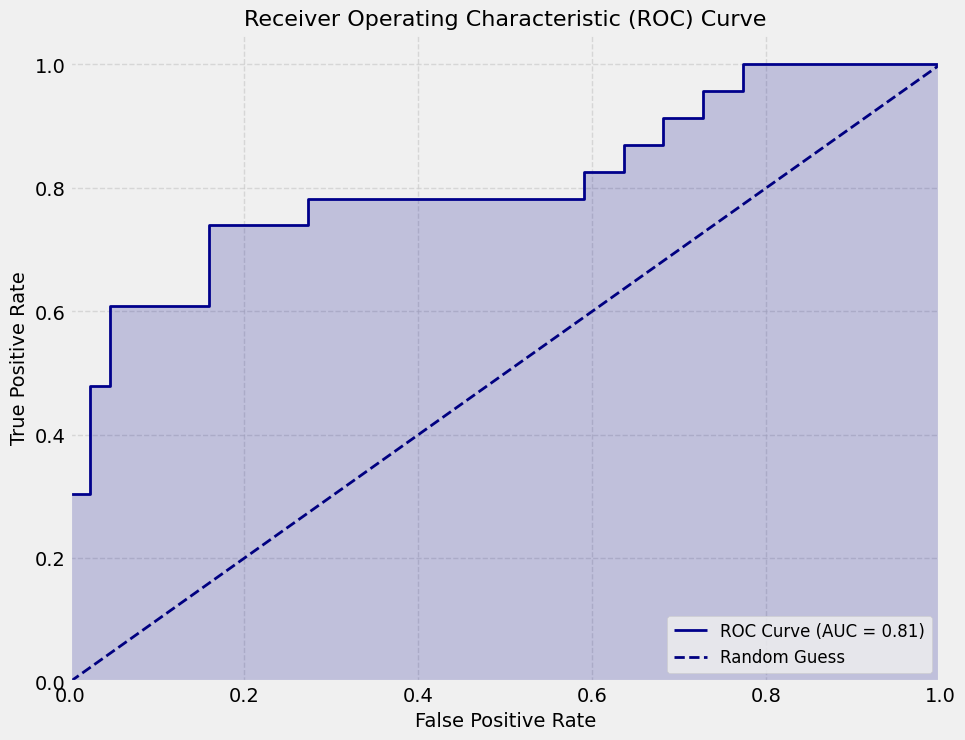

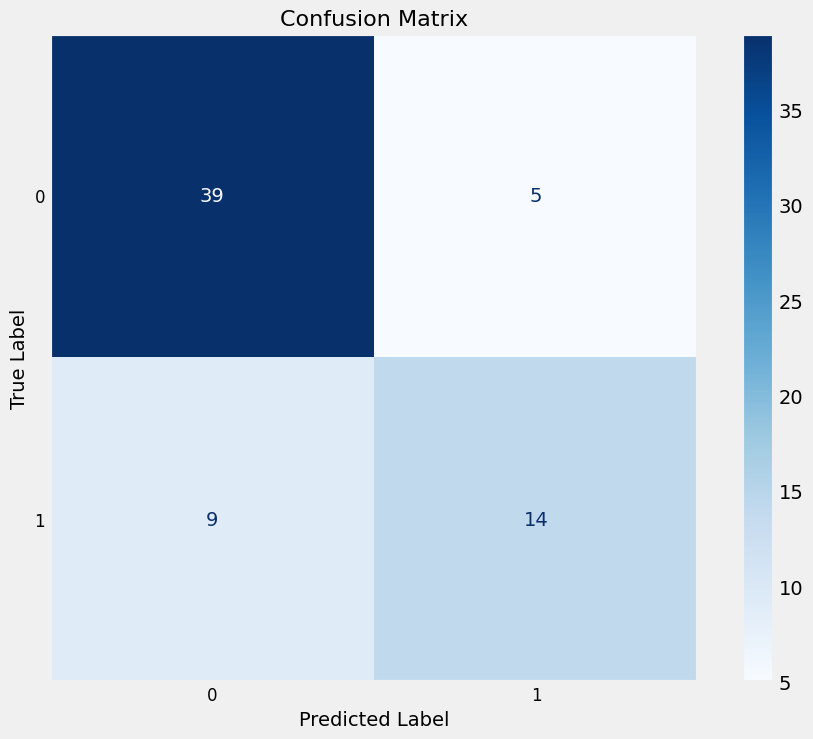

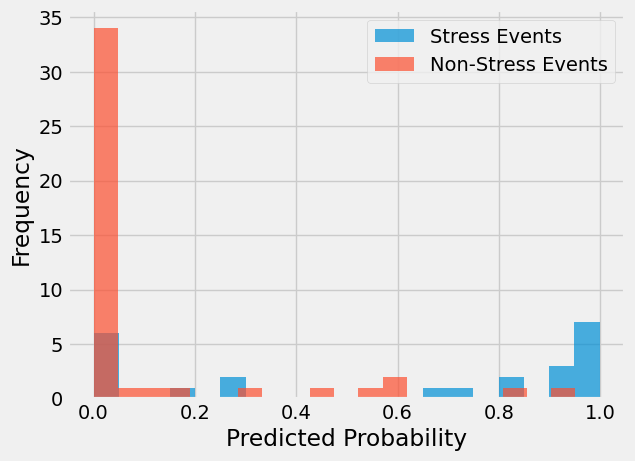

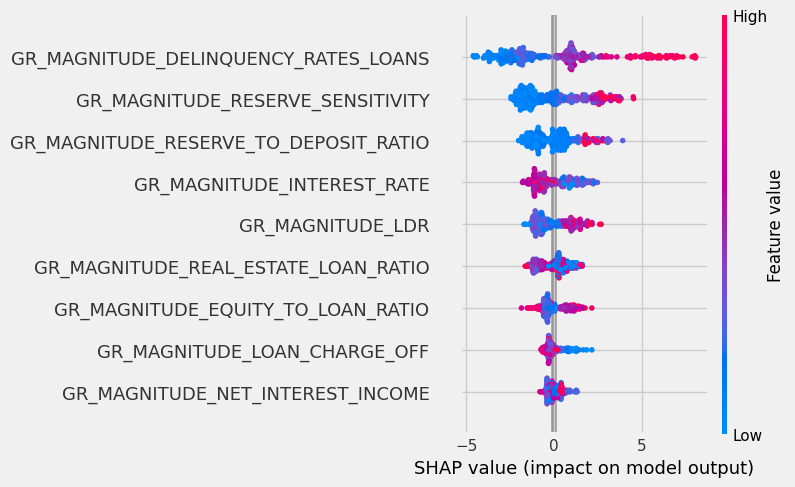

In [588]:
# Evaluating the model on the test set
evaluation_functions.model_evaluation(test_df, xgb_model, 'STRESS_FLAG')
# Plotting the SHAP values for the top 10 features
evaluation_functions.plot_shap_values(xgb_model, train_df.drop(columns = ['STRESS_FLAG']), 10)

In [ ]:
'''
For the frequency plot: 
    - The model is generally confident in distinguishing between stress and non-stress events for extreme probabilities (close to 0 or 1).
    - Overlap in mid-range probabilities (0.2-0.6) suggests that the model struggles with borderline cases
For the SHAP Summary Plot:
    - GR_MAGNITUDE_DELINQUENCY_RATES_LOANS: High values (red) positively contribute to stress event predictions, 
      suggesting that higher loan delinquency rates strongly indicate stress.
    - GR_MAGNITUDE_RESERVE_SENSITIVITY: Low reserve sensitivity (blue) negatively contributes to stress predictions.
      This indicates that less sensitivity of reserves to macroeconomic changes reduces stress risk.
    - GR_MAGNITUDE_RESERVE_TO_DEPOSIT_RATIO: High values contribute positively to stress predictions, indicating a potential liquidity constraint.
    - Regarding LDR & Interest rates: High interest rates and loan-to-deposit ratios are positively associated with stress events, aligning with financial instability indicators.
    - General Insight: Features such as loan delinquency rates and reserve-related metrics dominate the model's decision-making process, 
      which aligns with economic stress indicators.
For the ROC AUC Score (0.81): This indicates that the model has a good ability to distinguish between stress and non-stress events.
However, when looking at the classification report we can observe a moderate number of recall score regarding stress events. 
This can confirm our first observation made from the frequency plot, that the model struggles with borderline cases.
When doing further analysis and performing various scenarios using Monte Carlo Simulation, we will be able to determine where exactly does the model starts to fail.

'''

## 5.2 Focused Evaluation

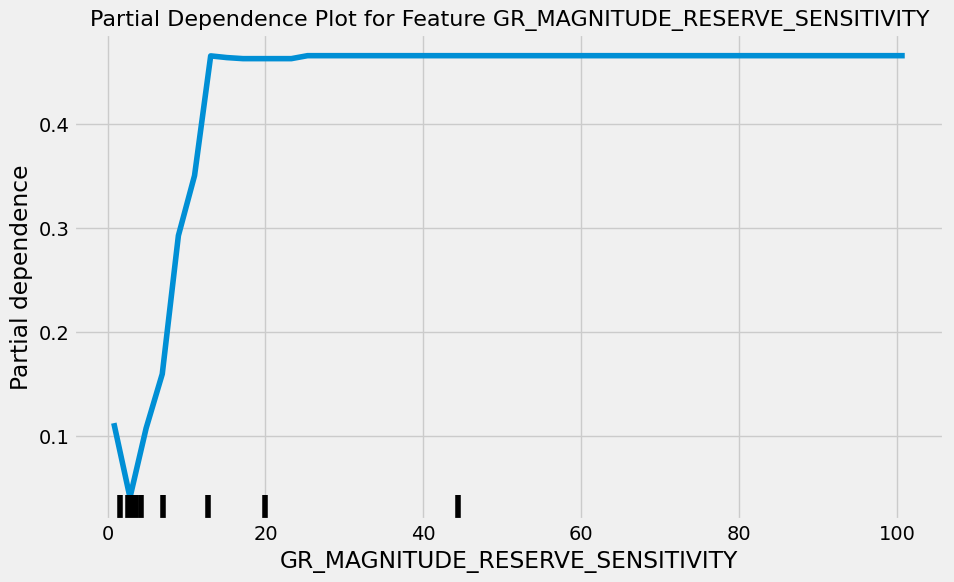

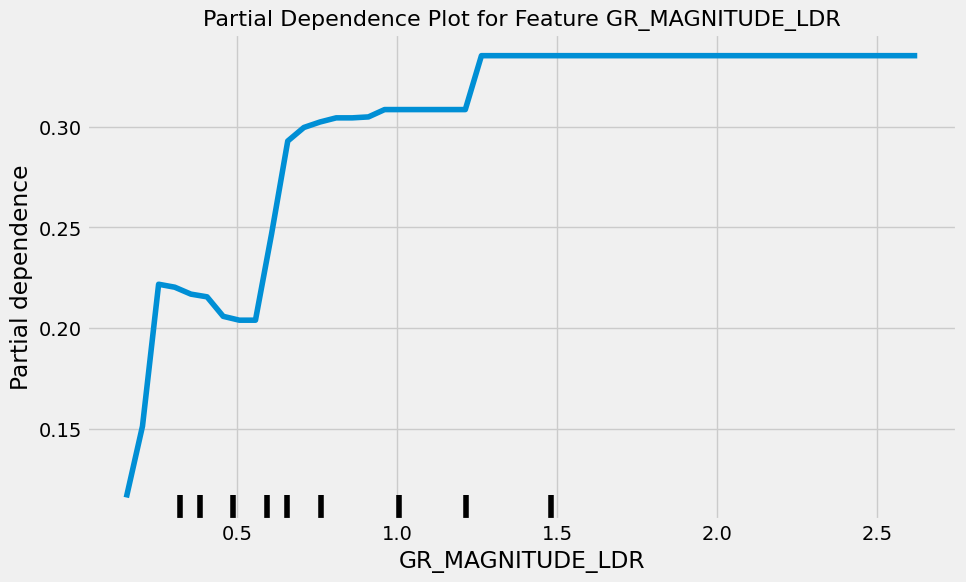

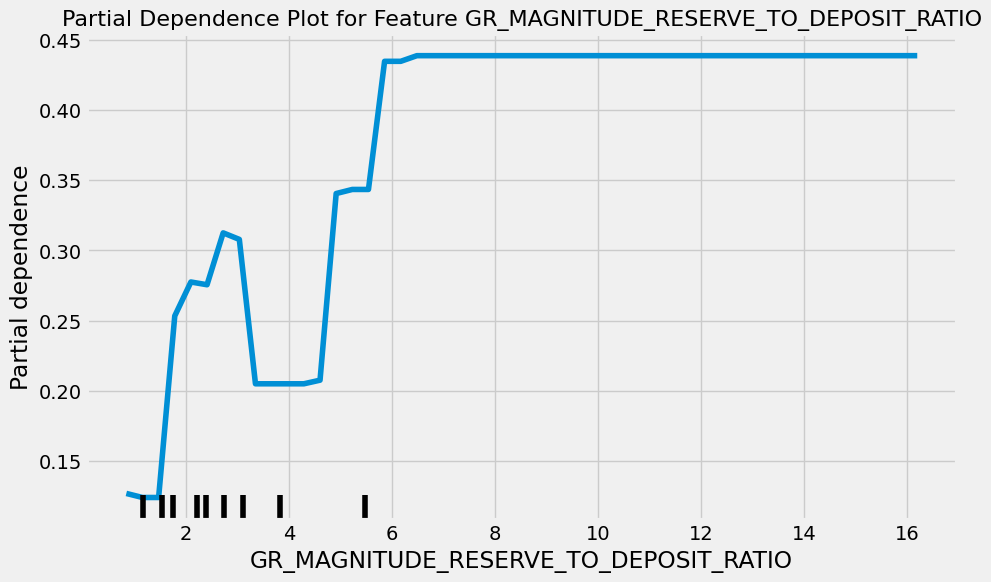

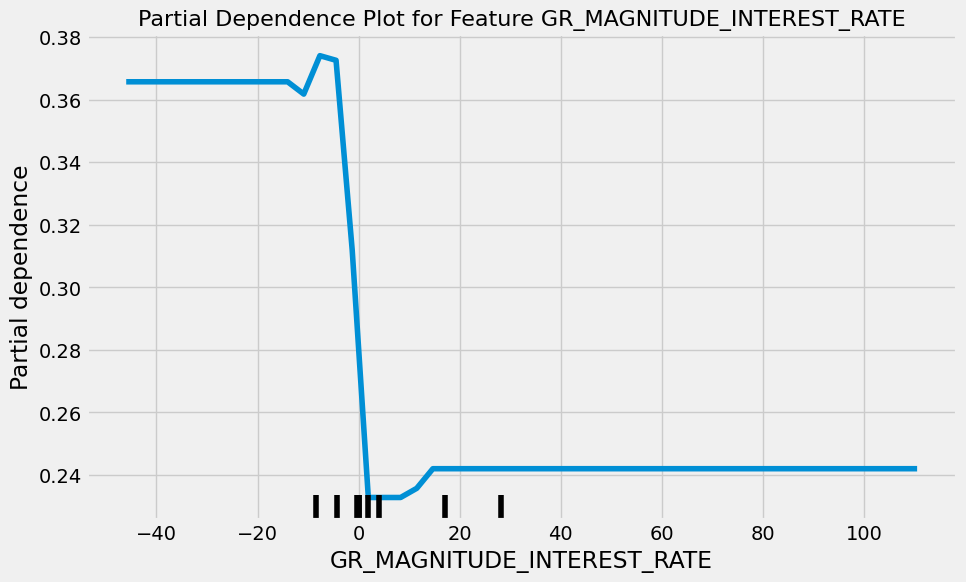

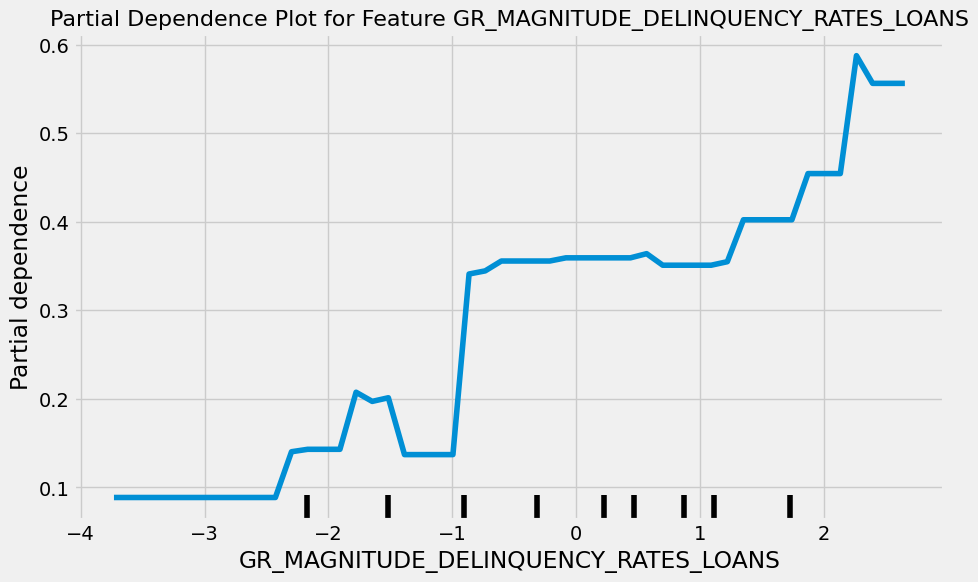

In [611]:
# Selecting TOP 5 features based on model's feature importance:
top_features = ['GR_MAGNITUDE_DELINQUENCY_RATES_LOANS', 
                'GR_MAGNITUDE_RESERVE_SENSITIVITY', 
                'GR_MAGNITUDE_RESERVE_TO_DEPOSIT_RATIO', 
                'GR_MAGNITUDE_LDR', 
                'GR_MAGNITUDE_INTEREST_RATE', 
                ]

evaluation_functions.plot_partial_dependency(xgb_model, test_df, top_features)

In [ ]:
'''
Insights from PDP:
    - GR_MAGNITUDE_DELINQUENCY_RATES_LOANS: As delinquency rates increase, the likelihood of stress events rises steadily, showing a strong positive relationship.
      This confirms our observation made in the previous section that high delinquency rates are a significant contributor to financial stress.
    - GR_MAGNITUDE_INTEREST_RATE: The predicted probability of stress drops sharply when interest rates are near or below 0, but remains constant for higher values.
      This suggests that near-zero or negative interest rates are critical indicators of financial stability.
    - GR_MAGNITUDE_LDR: Higher LDR values lead to an increased probability of stress, especially above a threshold of 1.
      This shows that excessive lending relative to deposits is a major driver of financial stress.
    - GR_MAGNITUDE_RESERVE_SENSITIVITY: Reserve sensitivity has a steep positive impact on stress probabilities up to a certain point, after which it levels off.
      This highlights that reserves' responsiveness to economic changes is a critical early indicator of stress.
    - GR_MAGNITUDE_RESERVE_TO_DEPOSIT_RATIO: The probability of stress events increases with higher reserve-to-deposit ratios, particularly beyond a ratio of 6.
      This implies that excessive reserves relative to deposits may signal liquidity constraints or inefficient capital allocation. 
      (THIS INSIGHT IS VERY IMPORTANT FOR ANOTHER UPCOMING PROJECT)
'''

# 6. Model Prediction

In [591]:
def add_model_predictions(xgb_model, X_test, y_test):
    """
    Adds model predictions as a new column to the test DataFrame.

    Parameters:
        xgb_model (XGBClassifier): Trained XGBoost model.
        X_test (pd.DataFrame or np.ndarray): Test features.
        y_test (pd.Series, pd.DataFrame, or np.ndarray): True labels corresponding to the test features.

    Returns:
        pd.DataFrame: A DataFrame with true labels and model predictions.
    """
    # Ensuring X_test is a DataFrame
    X_test = pd.DataFrame(X_test) if not isinstance(X_test, pd.DataFrame) else X_test

    # Converting y_test to a Series if it's not already
    if isinstance(y_test, pd.DataFrame):
        y_test = y_test.iloc[:, 0]                  # Taking the first column if it's a DataFrame
    elif not isinstance(y_test, pd.Series):
        y_test = pd.Series(y_test)                  # Converting numpy array to Series

    # Making predictions
    predictions = xgb_model.predict(X_test)

    # Creating a DataFrame with true labels and predictions
    results_df = X_test.copy()                      # Copying X_test to include the features
    results_df['TRUE_LABEL'] = y_test.values        # Adding the true labels
    results_df['MODEL_PREDICTION'] = predictions    # Adding the model predictions

    return results_df

X_test = test_df.drop(columns=['STRESS_FLAG'])
y_test = test_df[['STRESS_FLAG']]
results_with_predictions = add_model_predictions(xgb_model, X_test, y_test)

# Viewing the top 50 results
results_with_predictions[['TRUE_LABEL', 'MODEL_PREDICTION']].head(50)

,TRUE_LABEL,MODEL_PREDICTION
DATE,,
2019-01,0,0
2019-02,0,0
2019-03,0,0
2019-04,0,0
2019-05,0,0
2019-06,0,0
2019-07,0,0
2019-08,0,0
2019-09,0,0


# 7. Saving Best Model

In [592]:
# Saving the model to a .pkl file
dump(xgb_model, 'stress_best_model.pkl')

['stress_best_model.pkl']